In [1]:
import collections
import os
import pathlib
import json

DATA_DIR = pathlib.Path('.') / 'data'
techniques_count = collections.defaultdict(int)

for fn in os.listdir(DATA_DIR.absolute()):
    data_path = DATA_DIR / fn
    with data_path.open() as f:
        data = json.load(f)
    for tech in data['techniques']:
        tech_id = tech['techniqueID'].split('.')[0]
        techniques_count[tech_id] += 1

print(techniques_count)

defaultdict(<class 'int'>, {'T1078': 30, 'T1087': 28, 'T1071': 66, 'T1560': 47, 'T1547': 71, 'T1059': 148, 'T1543': 26, 'T1213': 4, 'T1005': 18, 'T1114': 15, 'T1041': 8, 'T1133': 10, 'T1083': 19, 'T1056': 36, 'T1036': 41, 'T1003': 73, 'T1069': 12, 'T1057': 19, 'T1021': 59, 'T1018': 14, 'T1558': 2, 'T1082': 20, 'T1016': 20, 'T1049': 13, 'T1007': 6, 'T1569': 10, 'T1548': 16, 'T1119': 7, 'T1074': 35, 'T1030': 1, 'T1140': 14, 'T1189': 14, 'T1203': 18, 'T1068': 8, 'T1210': 2, 'T1574': 20, 'T1562': 20, 'T1551': 63, 'T1105': 29, 'T1112': 11, 'T1046': 11, 'T1027': 68, 'T1055': 25, 'T1012': 7, 'T1053': 49, 'T1505': 18, 'T1047': 14, 'T1566': 103, 'T1204': 83, 'T1555': 26, 'T1048': 12, 'T1222': 2, 'T1564': 25, 'T1571': 6, 'T1137': 3, 'T1218': 49, 'T1216': 2, 'T1072': 2, 'T1033': 17, 'T1550': 16, 'T1091': 2, 'T1518': 16, 'T1553': 24, 'T1080': 2, 'T1187': 2, 'T1221': 4, 'T1095': 3, 'T1546': 26, 'T1037': 4, 'T1573': 20, 'T1559': 17, 'T1572': 3, 'T1219': 5, 'T1220': 1, 'T1090': 25, 'T1039': 3, 'T1135

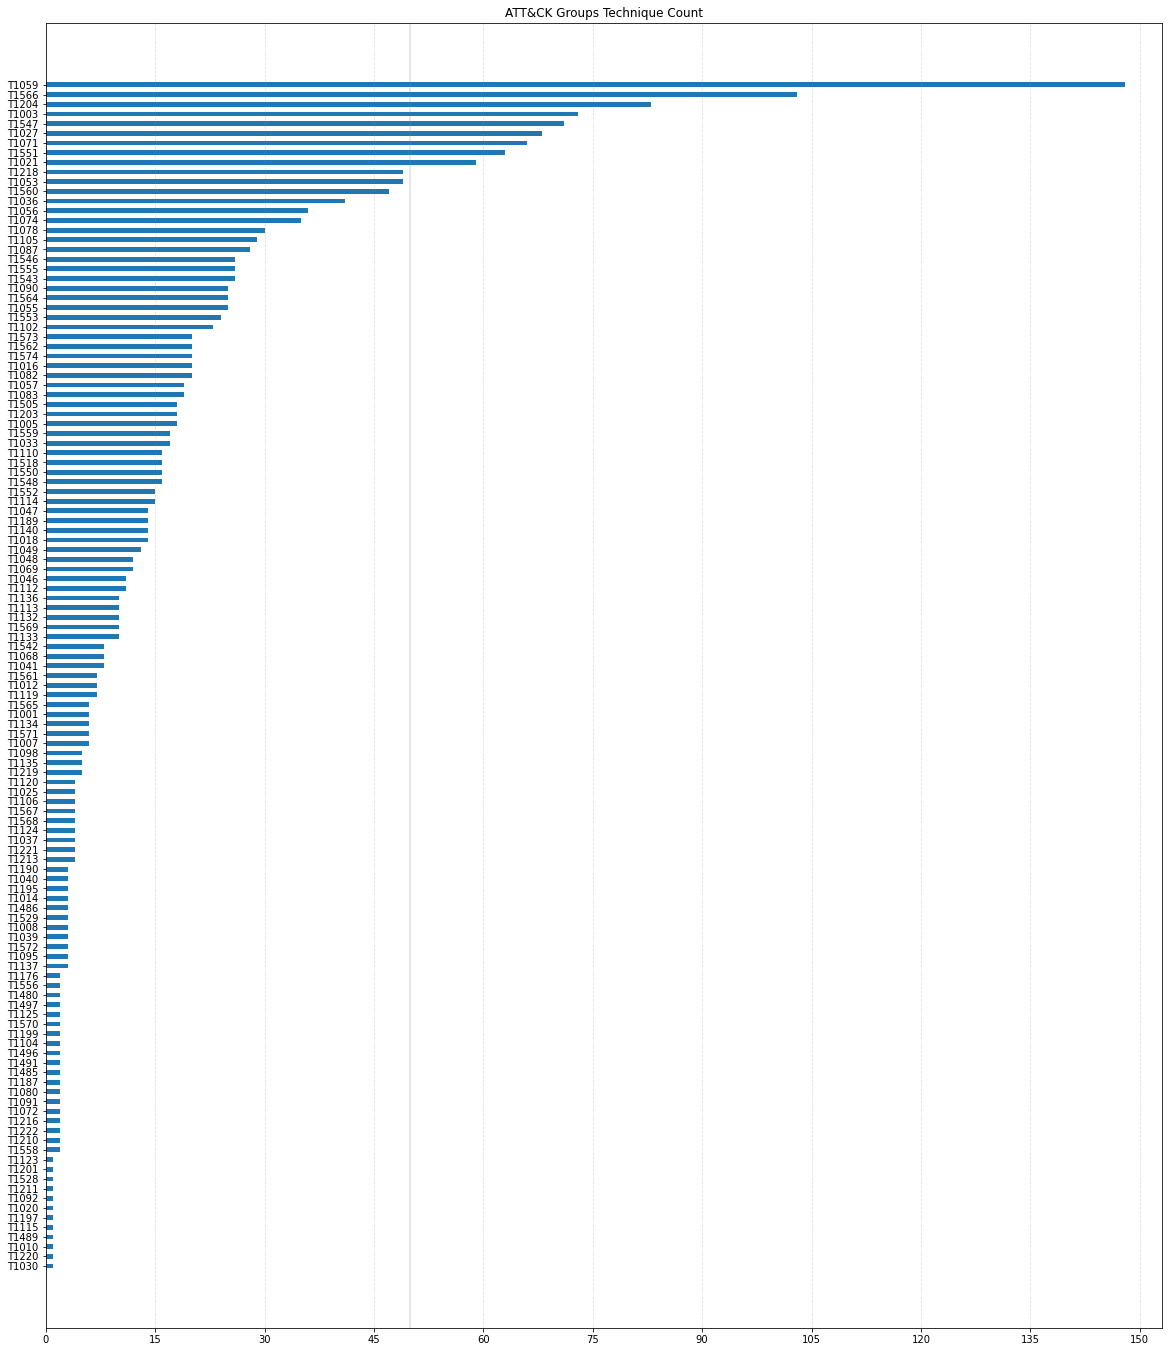

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

technique_ids = list(techniques_count.keys())
technique_ids.sort(key=lambda tech_id: techniques_count[tech_id])


fig, ax = plt.subplots(figsize=(20, 24))
fig.canvas.set_window_title('Test')

pos = np.arange(len(technique_ids))
rects = ax.barh(pos, [techniques_count[tech_id] for tech_id in technique_ids], 
                align='center', height=0.5, tick_label=technique_ids)
ax.set_title('ATT&CK Groups Technique Count')
ax.set_xlim([0, max(techniques_count.values()) + 5])
ax.xaxis.set_major_locator(MaxNLocator(11))
ax.xaxis.grid(True, linestyle='--', which='major',
            color='grey', alpha=.25)
ax.axvline(50, color='grey', alpha=0.25)
plt.show()

In [4]:
import requests
import functools
import numpy as np

from crawler import crawl_enterprise_matrix

session = requests.Session()
matrix = crawl_enterprise_matrix(session)
techniques = set()
techniques_list = []
for tactic in matrix:
    for tech in matrix[tactic]:
        techniques.add(tech.id)

tech_index_map = {}
for i, tech in enumerate(sorted(techniques)):
    tech_index_map[tech] = i


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155]
